<a href="https://colab.research.google.com/github/ArturoAntonioSotoOsornio/DMUNAM2025/blob/HuertaOrozcoYagoRaul_317071641/Pr%C3%A1ctica_3_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importamos las dependencias**

In [165]:
# Para el manejo de datos y el cómputo científico
import numpy as np
import pandas as pd

# Para graficar
import matplotlib.pyplot as plt
import cufflinks as cf
import seaborn as sns

# Para imputar variables continuas
from sklearn.impute import SimpleImputer
from scipy.stats import ks_2samp

# Para hacer los modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Para hacer tratamiento a tus datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Para guardar el modelo
import pickle

# **Cargamos los datos**

In [129]:
df = pd.read_csv("/content/drive/MyDrive/Apuntes/Octavo semestre/Minería de datos/Programas/Práctica 3/titanic.csv")

# **Ingeniería de datos**

In [4]:
### Veamos cuantos datos hay
df.shape

(1310, 14)

In [95]:
### Veamos cuantos nulos hay (en porcentaje)
def cant_nulos(df):
  return df.isnull().sum().sort_values(ascending=False) / df.shape[0]

cant_nulos(df)

,0
body,0.907634
cabin,0.774809
boat,0.629008
home.dest,0.431298
age,0.201527
embarked,0.002290
fare,0.001527
sibsp,0.000763
name,0.000763
survived,0.000763


Vemos que tenemos una cantidad muy alta de nulos. Además, las columnas de **body**, **cabin**, **boat**, **home.dest**, **name** y **ticket** no creo que vayan a aportar mucho al modelo. Así que vamos a eliminarlas

### **Tratamiento de los nulos**

In [130]:
eliminar = ['body', 'cabin', 'boat', 'home.dest', 'name', 'ticket'] # Columnas que vamos a eliminar

df = df.drop(eliminar, axis=1) # Las eliminamos

In [131]:
cant_nulos(df)

,0
age,0.201527
embarked,0.002290
fare,0.001527
pclass,0.000763
sex,0.000763
survived,0.000763
parch,0.000763
sibsp,0.000763


In [132]:
# Exceptuando la columna de 'age', vemos que el porcentaje de nulos que tenemos en el resto de las columnas es menor al 0.5%
# entonces vamos a eliminarlos directamente del df, pues casi no vamos a perder información
df = df[(~df["survived"].isnull()) & ~df["pclass"].isnull() & ~df["fare"].isnull() & ~df["embarked"].isnull() ]

In [133]:
df.shape # Originalmente teníamos 1310 filas, y ahora 1306

(1306, 8)

<Axes: xlabel='age', ylabel='Count'>

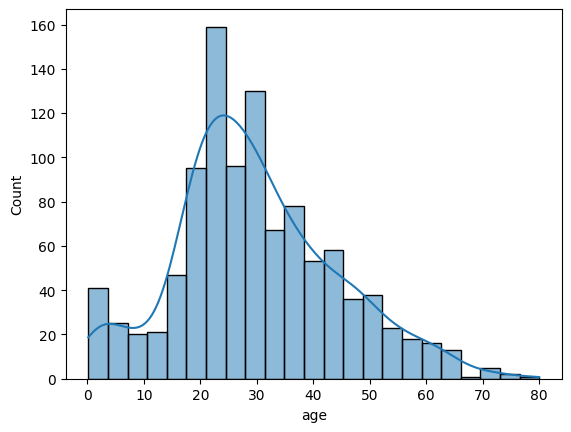

In [134]:
# Veamos cómo se distibuye la variable 'age'
sns.histplot(df['age'], kde = True)

Prueba

In [135]:
X = df[['age']].copy()
Xi = pd.DataFrame(df['age'].copy().ffill(), columns=['age'])

ks_2samp(X.dropna(), Xi)

KstestResult(statistic=array([0.01464441]), pvalue=array([0.99945115]), statistic_location=array([21.]), statistic_sign=array([1.]))

In [136]:
df['age'] = Xi

<Axes: xlabel='age', ylabel='Count'>

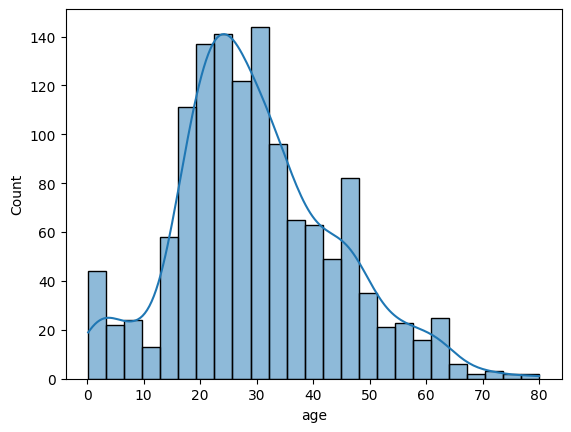

In [137]:
sns.histplot(df['age'], kde = True)

Fin prueba

In [19]:
df['age'].mean(), df['age'].median()

(np.float64(29.813199137104508), 28.0)

Por la forma de la distribución, creo que la mejor imputación que podemos hacer es con la mediana, pero también lo vamos a intentar con la media

In [20]:
### Imputamos la variable 'age'

X = df[['age']].copy()
im = SimpleImputer(strategy='median') # Lo intentamos con la mediana
Xi = pd.DataFrame(im.fit_transform(X), columns=['age']) # Imputamos los datos


### Hacemos la prueba estadística

# Cómo es una variable contínua, usamos la prueba de kolmogorov
ks_2samp(X.dropna(), Xi)

KstestResult(statistic=array([0.09788953]), pvalue=array([2.70208201e-05]), statistic_location=array([28.]), statistic_sign=array([-1.]))

<Axes: ylabel='Count'>

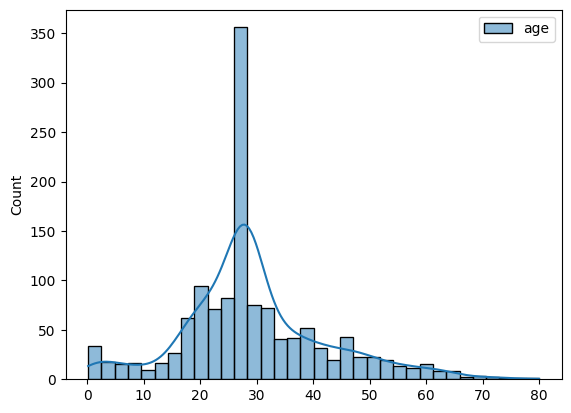

In [21]:
sns.histplot(Xi, kde = True)

Con la gráfica, se puede ver que si cambió mucho la distribución de los datos. Esto confirma lo que nos dice el p-value

In [22]:
### Imputamos la variable 'age'

X = df[['age']].copy()
im = SimpleImputer(strategy='mean') # Lo intentamos con la mediana
Xi = pd.DataFrame(im.fit_transform(X), columns=['age']) # Imputamos los datos


### Hacemos la prueba estadística

# Cómo es una variable contínua, usamos la prueba de kolmogorov
ks_2samp(X.dropna(), Xi)

KstestResult(statistic=array([0.10986024]), pvalue=array([1.48109162e-06]), statistic_location=array([29.]), statistic_sign=array([1.]))

<Axes: ylabel='Count'>

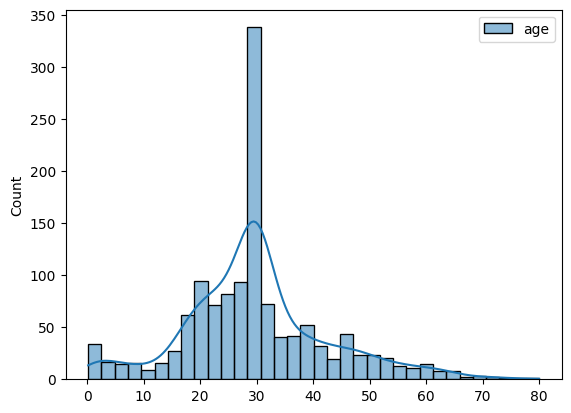

In [23]:
sns.histplot(Xi, kde = True)

A pesar de que ambas estrategias cambian significativamente la distribución(p-value), el KS en la estrategia de la mediana, el valor es menor a 0.1 (el recomendado por el profesor), así que nos vamos a quedar con ese. Pues indica que la máxima diferencia absoluta entre ambas distribuciones es menor que 0.1

In [24]:
X = df[['age']].copy()
im = SimpleImputer(strategy='median') # Lo intentamos con la mediana
df['age'] = im.fit_transform(df[['age']].copy()) # Guardamos los datos imputados

In [93]:
### Vemos que, efectivamente ya no hay datos nulos
cant_nulos(df)

,0
pclass,0.0
survived,0.0
sex,0.0
age,0.0
sibsp,0.0
parch,0.0
fare,0.0
embarked,0.0
body,0.0


**Temporal**

<Axes: xlabel='body', ylabel='Count'>

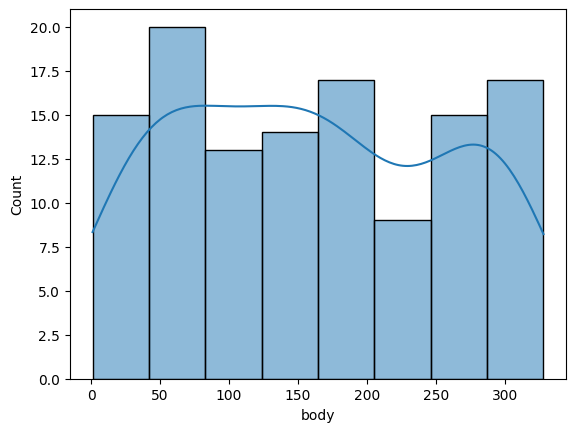

In [26]:
sns.histplot(df['body'], kde=True)

In [86]:
### imputamos la variable 'body'
X = df[['body']].copy()

# Rellenamos los nulos con el valor no nulo anterior
Xi = pd.DataFrame(df['body'].copy().ffill(), columns=['body']) # Aquí vamos a tener aún 3 nulos

# Imputamos los 3 valores nulos con la media
im = SimpleImputer(strategy='mean')
Xj = pd.DataFrame(im.fit_transform(Xi), columns=['body'])

# Hacemos la prueba estadística
ks_2samp(X.dropna(), Xj)

KstestResult(statistic=array([0.09183257]), pvalue=array([0.29254452]), statistic_location=array([131.]), statistic_sign=array([1.]))

Tanto el valor del ks (menor a 0.1) como el p-value (mayor a 0.05) nos indican que la imputación fue un rotundo éxito

In [90]:
cant_nulos(df)

,0
pclass,0.0
survived,0.0
sex,0.0
age,0.0
sibsp,0.0
parch,0.0
fare,0.0
embarked,0.0
body,0.0


<Axes: xlabel='body', ylabel='Count'>

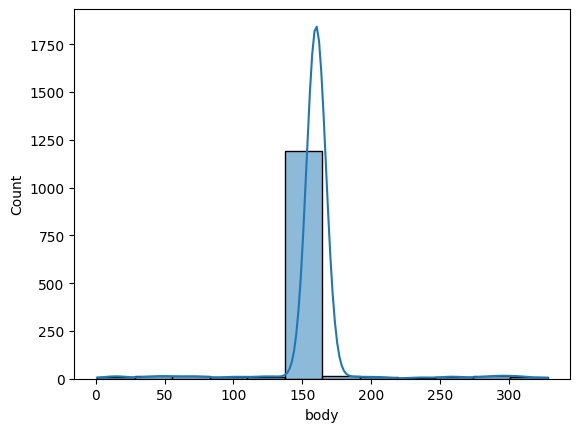

In [92]:
sns.histplot(df['body'], kde=True)

### **Clasificación de las variables**

In [138]:
df.sample(n = 10, random_state=1)

,pclass,survived,sex,age,sibsp,parch,fare,embarked
646,3.0,1.0,female,38.0,1.0,5.0,31.3875,S
1034,3.0,1.0,male,34.0,1.0,1.0,15.2458,C
163,1.0,1.0,female,35.0,1.0,0.0,52.0000,S
1011,3.0,0.0,female,19.0,1.0,0.0,16.1000,S
911,3.0,0.0,male,21.0,0.0,0.0,8.4333,S
269,1.0,0.0,male,24.0,0.0,0.0,26.0000,S
1137,3.0,0.0,male,24.0,0.0,0.0,7.2292,C
985,3.0,1.0,male,24.0,0.0,0.0,7.1417,S
1114,3.0,0.0,male,26.0,0.0,0.0,7.0000,S
906,3.0,0.0,male,27.0,0.0,0.0,7.8542,S


Según el diccionario de datos que está en Kaggle, y por los datos que hay en el df, tenemos lo siguiente:


* **pclass**: Discreta
* **survived**: Discreta
* **sex**: Discreta
* **age**: Contínua
* **sibsp**: Discreta
* **parch**: Discreta
* **fare**: Contínua
* **embarked**: Discreta


In [139]:
### Mapeo de las variables discretas


### sex
sexo = {'male':0, 'female':1}
df['sex'] = df['sex'].map(sexo)

### embarked
embarked = {'C':0, 'Q':1, 'S': 2}
df['embarked'] = df['embarked'].map(embarked)

In [140]:
### Casteo de float a int


### pclass
df['pclass'] = df['pclass'].astype(int)

### survived
df['survived'] = df['survived'].astype(int)

### sibsp
df['sibsp'] = df['sibsp'].astype(int)

### parch
df['parch'] = df['parch'].astype(int)

In [141]:
### Vemos el resultado de nuestros cambios
df.sample(n = 10, random_state=1)

,pclass,survived,sex,age,sibsp,parch,fare,embarked
646,3,1,1,38.0,1,5,31.3875,2
1034,3,1,0,34.0,1,1,15.2458,0
163,1,1,1,35.0,1,0,52.0000,2
1011,3,0,1,19.0,1,0,16.1000,2
911,3,0,0,21.0,0,0,8.4333,2
269,1,0,0,24.0,0,0,26.0000,2
1137,3,0,0,24.0,0,0,7.2292,0
985,3,1,0,24.0,0,0,7.1417,2
1114,3,0,0,26.0,0,0,7.0000,2
906,3,0,0,27.0,0,0,7.8542,2


# **Pre-entrenamiento**

### **Definición de las variables**

In [142]:
### Definimos las variables que clasificamos
tgt = 'survived'
varc = ['age', 'fare']
vard = [x for x in list(df.columns) if x not in varc+[tgt]]

### Definimos las variables independiente y dependiente
X = df[varc + vard].copy()
y = df[tgt].copy()

### **Escalamiento de datos**

In [143]:
sc = MinMaxScaler() # Instanciamos al escalador
Xs = pd.DataFrame(sc.fit_transform(X), columns=varc+vard)

### **Partición de los datos**

In [144]:
Xt, Xv, yt, yv = train_test_split(Xs, y, train_size=0.7, random_state=42)

# **Modelado**

### **Funciones**

In [156]:
def entrenar(param, modelo, X, y):
    """
    Entrena un modelo de aprendizaje automático utilizando búsqueda aleatoria de hiperparámetros.

    Args:
        param (dict): Diccionario que define el espacio de búsqueda de los hiperparámetros.
                      Las claves son los nombres de los hiperparámetros y los valores son
                      listas de posibles valores o distribuciones de las que se tomarán muestras.
        modelo: El modelo de aprendizaje automático que se va a entrenar (ej. RandomForestClassifier).
        X (pd.DataFrame): Las características de entrenamiento.
        y (pd.Series): La variable objetivo o las etiquetas de entrenamiento.

    Returns:
        tuple: Una tupla que contiene los siguientes elementos:
            - grid (RandomizedSearchCV): El objeto RandomizedSearchCV ajustado.
            - best_estimator_: El mejor modelo encontrado durante la búsqueda.
            - best_score_ (float): La mejor puntuación (resultado de la validación cruzada) obtenida.
            - best_params_ (dict): Un diccionario con los mejores valores de los hiperparámetros encontrados.
    """
    grid = RandomizedSearchCV(
        param_distributions=param,
        n_jobs=-1,
        n_iter=50,
        cv=8,
        estimator=modelo,
        error_score='raise'
    )

    grid.fit(X, y)

    return grid, grid.best_estimator_, grid.best_score_, grid.best_params_

In [157]:
def metricas(Xt, Xv, yt, yv, modelo):

    d = {
        'train':round(roc_auc_score(y_true=yt, y_score=modelo.predict_proba(Xt)[:,1]),3),
         'validate':round(roc_auc_score(y_true=yv, y_score=modelo.predict_proba(Xv)[:,1]),3)
        }

    return d

### **Red Neuronal**

In [158]:
### Instanciamos el modelo
modelo_mlpc = MLPClassifier()

### Creamos un diccionario para definir nuestro espacio híperparamétrico

param_mlpc = dict(
             hidden_layer_sizes = [(a,b,c,) for a in range(1, 100) for b in range(1, 100) for c in range(1, 100)],
             activation = ['identity', 'logistic', 'tanh', 'relu'],
             solver = ['lbfgs', 'sgd', 'adam'],
             alpha = np.arange(0.0001, 0.001, 0.0001),
             learning_rate = ['constant', 'invscaling', 'adaptive'])

In [159]:
modelo_mlpc, best_estimator_mlpc, score_mlpc, params_mlpc = entrenar(param_mlpc, modelo_mlpc, Xt, yt)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [160]:
metricas(Xt,Xv,yt,yv,modelo_mlpc)

{'train': np.float64(0.89), 'validate': np.float64(0.853)}

Esto, nos da que en el train tenemos un $89$% de precisión en el conjunto 'train', y en el conjunto 'validate' un $85.3$%. Con lo cual, se cumple el requerimiento mínimo del profesor

<br>

Veamos los hiperparámetros de la red

In [162]:
best_estimator_mlpc

MLPClassifier(alpha=np.float64(0.0009000000000000001),
              hidden_layer_sizes=(49, 44, 43), learning_rate='invscaling')

In [164]:
params_mlpc

{'solver': 'adam',
 'learning_rate': 'invscaling',
 'hidden_layer_sizes': (49, 44, 43),
 'alpha': np.float64(0.0009000000000000001),
 'activation': 'relu'}

In [166]:
### Guardamos el modelo

filename = './redneuralYago.pkl'
with open(filename, 'wb') as file:
    pickle.dump(modelo_mlpc,file)

print(f'Modelo guardado en {filename}')

Modelo guardado en ./redneuralYago.pkl


### **Random Forest**

In [177]:
param = dict(n_estimators = range(2,10),
             max_depeth = range(2,6),
             max_features = range(2,len(varc)),
             criterion = ['gini', 'entropy']
             )

In [175]:
param = dict(n_estimators=list(range(1, 100, 25)),
                                    criterion=['gini', 'entropy'],
                                    max_depth=[x for x in list(range(2, 5))] + [None],
                                    min_samples_split=[x for x in list(range(2, 4))],
                                    min_samples_leaf=[x for x in list(range(2, 4))],
                                    max_features=[None] + [i * .05 for i in list(range(2, 4))],
                                    max_leaf_nodes=list(range(2, 10)) + [None],
                                    min_impurity_decrease=[x * .10 for x in list(range(2, 4))],
                                    oob_score=[True,False],
                                    warm_start=[True, False],
                                    class_weight=[None, 'balanced'],
                                    max_samples=[None]
             )

In [176]:
modelo = RandomForestClassifier()
modelo, best_estimator, score, params = entrenar(param, modelo, Xt, yt)
metricas(Xt,Xv,yt,yv,modelo)

{'train': np.float64(0.762), 'validate': np.float64(0.755)}

Este modelo salió mucho mejor que el del ejemplo del profesor, pasaron del $50$% tanto en el 'train' y en el 'validate', a un $76.2$% y $75.5$% en el 'train' y 'validate' respectivamente

In [178]:
filename = './randomforestYago.pkl'
with open(filename, 'wb') as file:
    pickle.dump(modelo_mlpc,file)

print(f'Modelo guardado en {filename}')

Modelo guardado en ./randomforestYago.pkl


### **Ada Boost**

In [183]:
param_adab = dict(n_estimators = range(2,10),
             learning_rate = np.arange(0.1,1,0.1),
             algorithm = ['SAMME']
                  )


In [184]:
modelo_adab = AdaBoostClassifier()
modelo_adab, best_estimator, score, params = entrenar(param_adab, modelo_adab, Xt, yt)
metricas(Xt,Xv,yt,yv,modelo_adab)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.



{'train': np.float64(0.852), 'validate': np.float64(0.822)}

Pasamos de $76.6$% a un $85.2$% en el conjunto 'train' y de $76.5$% a un $82.2$% en el conjunto 'validate'

In [185]:
filename = './adaboostYago.pkl'
with open(filename, 'wb') as file:
    pickle.dump(modelo_mlpc,file)

print(f'Modelo guardado en {filename}')

Modelo guardado en ./adaboostYago.pkl


### **Analisis Discriminante**

In [186]:
param_lda = dict(solver = ['svd', 'lsqr', 'eigen'])

In [187]:
modelo = LinearDiscriminantAnalysis()
modelo, best_estimator, score, params = entrenar(param_lda, modelo, Xt, yt)
metricas(Xt,Xv,yt,yv,modelo)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 3 is smaller than n_iter=50. Running 3 iterations. For exhaustive searches, use GridSearchCV.



{'train': np.float64(0.847), 'validate': np.float64(0.82)}

Pasamos de $71.3$% a un $84.7$% en el conjunto 'train' y de $72$% a un $82$% en el conjunto 'validate'

In [189]:
filename = './lineardiscriminantanalisisYago.pkl'
with open(filename, 'wb') as file:
    pickle.dump(modelo_mlpc,file)

print(f'Modelo guardado en {filename}')

Modelo guardado en ./lineardiscriminantanalisisYago.pkl


### **Maquina de Soporte Vectorial**

In [195]:
param_svc = dict(C = np.arange(0.1, 0.2, 0.01),
                kernel = ['linear','poly','rbf','sigmoid'],
                degree = range(2,6),
                gamma = ['scale','auto'],
                probability = [True])

In [196]:
modelo_svc = SVC()
modelo_svc, best_estimator, score, params = entrenar(param_svc, modelo_svc, Xt, yt)
metricas(Xt,Xv,yt,yv,modelo_svc)

{'train': np.float64(0.839), 'validate': np.float64(0.79)}

Aquí, no tenemos referencias de cuanto mejoró

In [197]:
filename = './suportvectormachineYago.pkl'
with open(filename, 'wb') as file:
    pickle.dump(modelo_mlpc,file)

print(f'Modelo guardado en {filename}')

Modelo guardado en ./suportvectormachineYago.pkl


# **Conclusiones**

Tan solo haciendo una mejora en la limpieza de los datos obtuvimos una mejora sustancial de casi el $10$% en casi todos los algoritmos. Y al menos la red neuronal si cumple con todos los requerimientos del profesor.